> # **Churn score**

Bank Customer Churn Prediction
Predicting customer churn in banking industry using machine learning.

> ## **Parametrage**

In [1]:
%pip install dill imblearn pendulum ucimlrepo yellowbrick loguru

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install--upgrade kagglehub

Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "install--upgrade" - maybe you meant "install"



In [3]:
import os
import zipfile
from pathlib import Path

import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pendulum
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from imblearn.pipeline import Pipeline as imb_Pipeline
from loguru import logger
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay,
                             PrecisionRecallDisplay)
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from ucimlrepo import fetch_ucirepo, list_available_datasets
from yellowbrick.classifier import DiscriminationThreshold

import warnings
warnings.filterwarnings(action='ignore')

set_config(display='diagram')
pd.set_option("display.max_columns", None)


In [4]:
plt.style.use('seaborn-v0_8-whitegrid')

In [5]:
def afficher_dataframes(dfs, head_n=5):
    """
    Affiche les informations d'un DataFrame ou d'un dictionnaire de DataFrames.

    Paramètres :
    - dfs : un DataFrame ou un dictionnaire {nom: DataFrame}
    - head_n : nombre de lignes à afficher avec head()
    """

    if isinstance(dfs, pd.DataFrame):
        # Cas d’un seul DataFrame
        print(f"\n📄 DESCRIPTION")
        print(f"📐 Taille : {dfs.shape[0]} lignes × {dfs.shape[1]} colonnes")
        print(f"🧠 Colonnes : {dfs.columns.tolist()}")
        display(dfs.head(head_n))

    elif isinstance(dfs, dict):
        if not dfs:
            print("⚠️ Dictionnaire vide.")
            return

        for name, df in dfs.items():
            if isinstance(df, pd.DataFrame):
                print(f"\n📄 Nom : {name}")
                print(f"📐 Taille : {df.shape[0]} lignes × {df.shape[1]} colonnes")
                print(f"🧠 Colonnes : {df.columns.tolist()}")
                display(df.head(head_n))
            else:
                print(f"⚠️ L’objet '{name}' n’est pas un DataFrame.")

    else:
        print("❌ Entrée non valide : fournir un DataFrame ou un dictionnaire de DataFrames.")


> ## **Collecting the data**

**About Dataset**

The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry.


It contains information on bank customers who either left the bank or continue to be a customer. 

The dataset includes the following attributes:

Customer ID: A unique identifier for each customer

Surname: The customer's surname or last name

Credit Score: A numerical value representing the customer's credit score

Geography: The country where the customer resides (France, Spain or Germany)

Gender: The customer's gender (Male or Female)

Age: The customer's age.

Tenure: The number of years the customer has been with the bank

Balance: The customer's account balance

NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)

HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)

IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)

EstimatedSalary: The estimated salary of the customer

Exited: Whether the customer has churned (1 = yes, 0 = no)

In [6]:
train_df = pd.read_csv("../data/playground-series-s4e1/train.csv")
test_df = pd.read_csv("../data/playground-series-s4e1/test.csv")
sample_df = pd.read_csv("../data/playground-series-s4e1/sample_submission.csv")

In [7]:
afficher_dataframes(train_df,head_n=5)


📄 DESCRIPTION
📐 Taille : 165034 lignes × 14 colonnes
🧠 Colonnes : ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [8]:
afficher_dataframes(test_df,head_n=5)


📄 DESCRIPTION
📐 Taille : 110023 lignes × 13 colonnes
🧠 Colonnes : ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [9]:
afficher_dataframes(sample_df,head_n=5)


📄 DESCRIPTION
📐 Taille : 110023 lignes × 2 colonnes
🧠 Colonnes : ['id', 'Exited']


,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


> ## Overviewing the data

In [10]:
train_df.shape,test_df.shape,sample_df.shape

((165034, 14), (110023, 13), (110023, 2))

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               110023 non-null  int64  
 1   CustomerId       110023 non-null  int64  
 2   Surname          110023 non-null  object 
 3   CreditScore      110023 non-null  int64  
 4   Geography        110023 non-null  object 
 5   Gender           110023 non-null  object 
 6   Age              110023 non-null  float64
 7   Tenure           110023 non-null  int64  
 8   Balance          110023 non-null  float64
 9   NumOfProducts    110023 non-null  int64  
 10  HasCrCard        110023 non-null  float64
 11  IsActiveMember   110023 non-null  float64
 12  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 10.9+ MB


> ## **Cleaning the data**

In [13]:
afficher_dataframes(train_df,head_n=5)


📄 DESCRIPTION
📐 Taille : 165034 lignes × 14 colonnes
🧠 Colonnes : ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [14]:
afficher_dataframes(test_df,head_n=5)


📄 DESCRIPTION
📐 Taille : 110023 lignes × 13 colonnes
🧠 Colonnes : ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


> ## **Missing values**

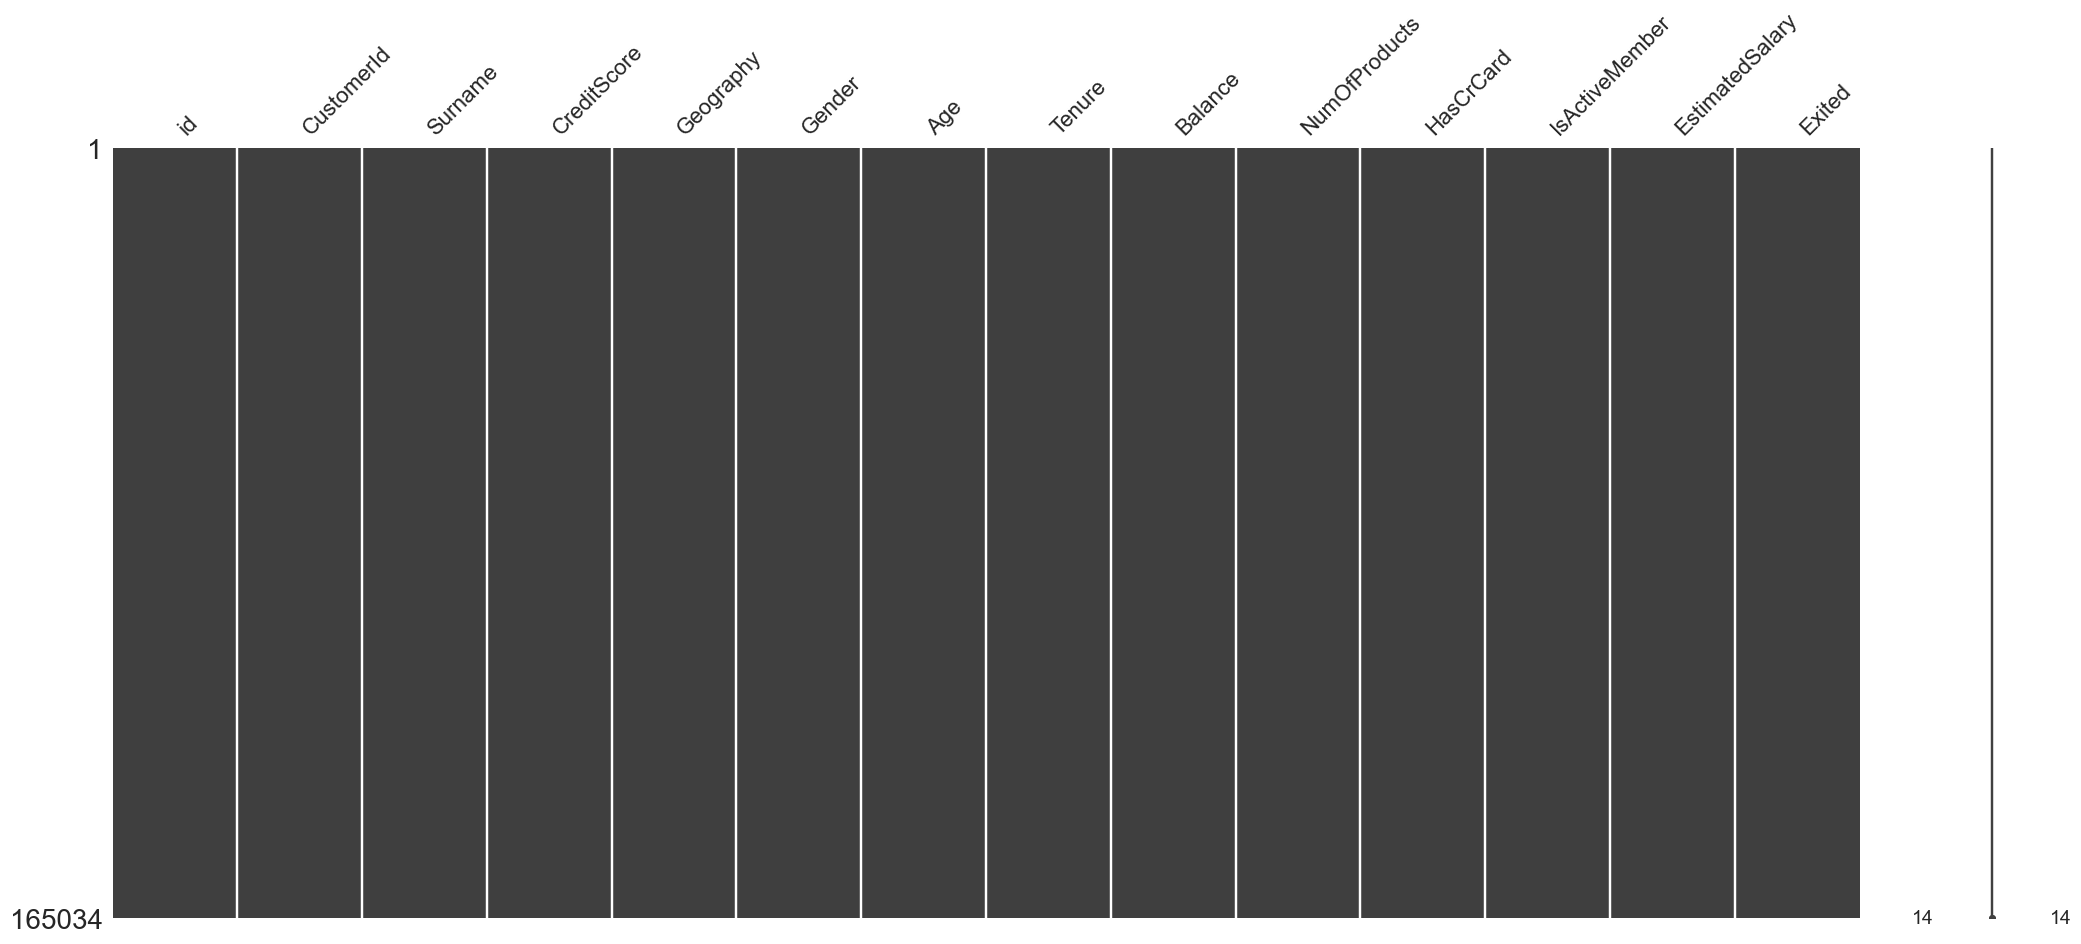

In [15]:
msno.matrix(train_df);

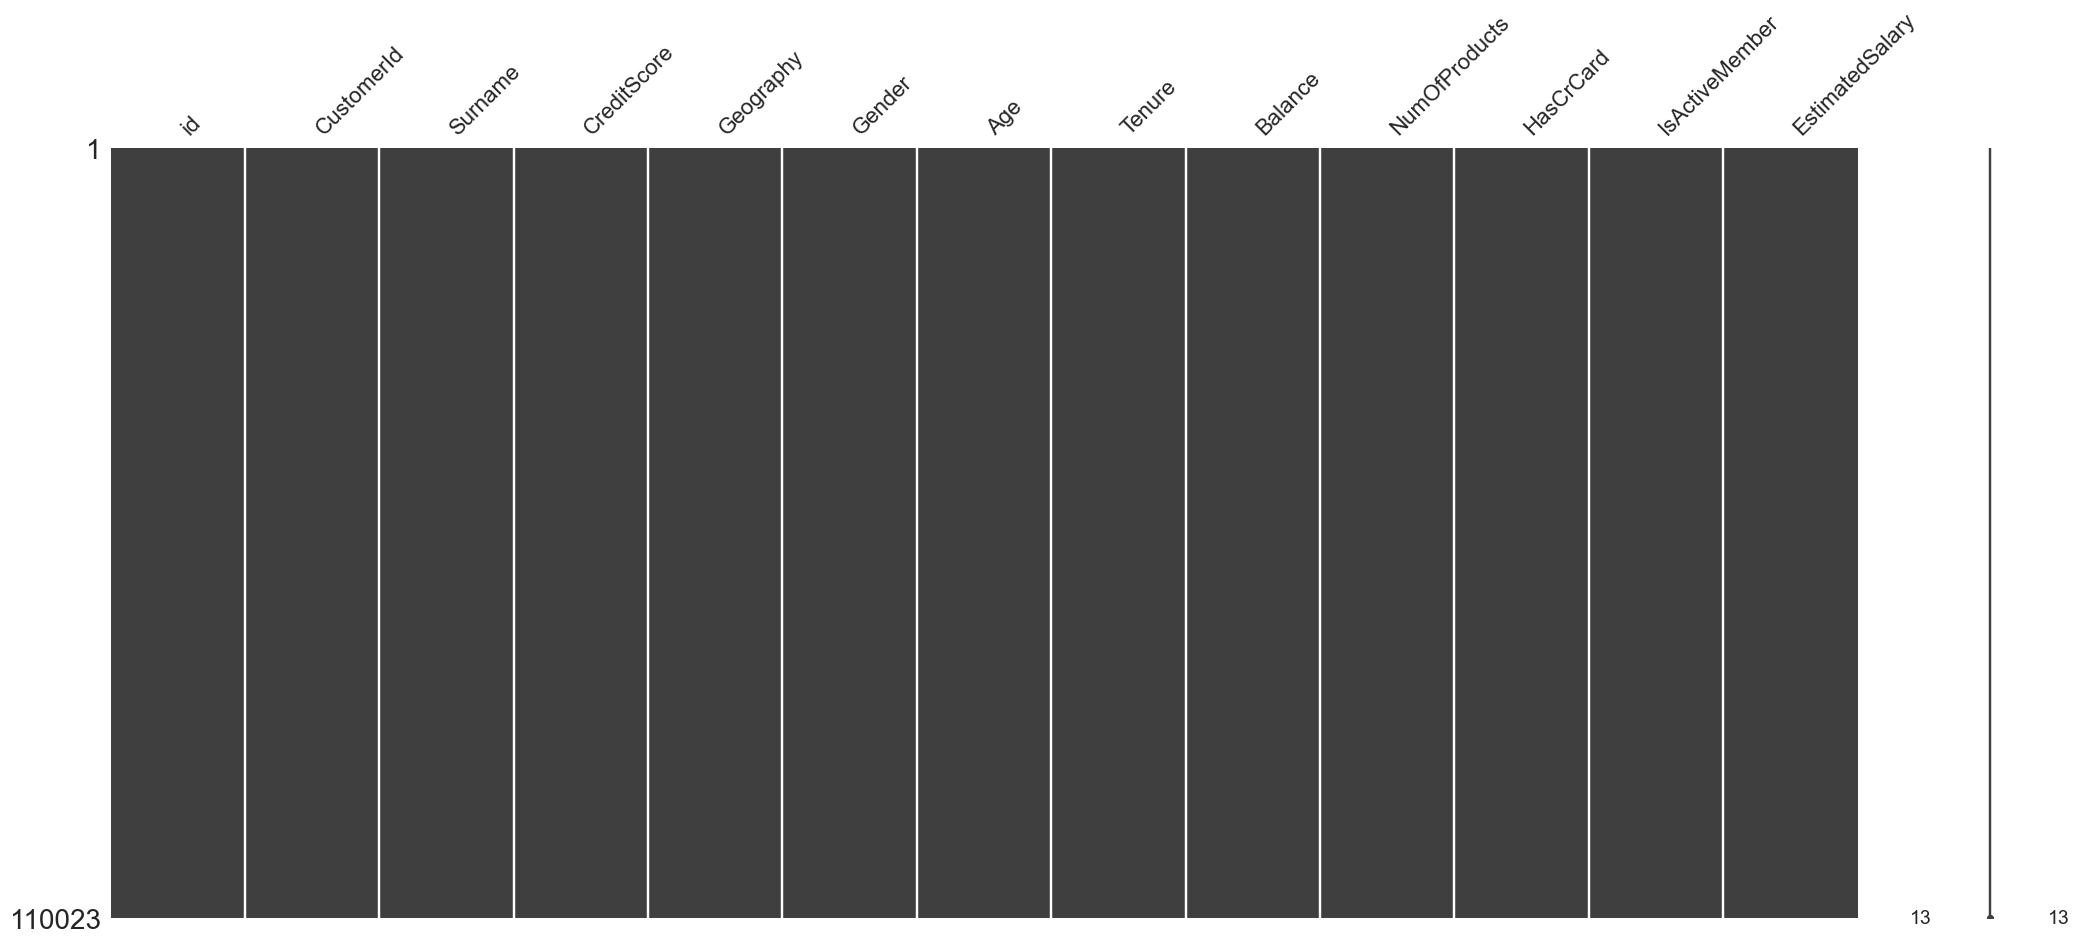

In [16]:
msno.matrix(test_df);

> ## Duplicated values

In [17]:
# Check for any duplicated values based on selected features
# keep=False means marking all duplicates
duplicated_value = train_df.duplicated(subset=["id"], keep=False)
df_customer_duplicate = train_df[duplicated_value].sort_values(by=["id"])

# Show any duplicated values
df_customer_duplicate

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [18]:
# Check for the duplicates: if True then there are duplicated
train_df.duplicated().any()

False

In [19]:
# Check for any duplicated values based on selected features
# keep=False means marking all duplicates
duplicated_value = test_df.duplicated(subset=["id"], keep=False)
df_customer_duplicate = test_df[duplicated_value].sort_values(by=["id"])

# Show any duplicated values
df_customer_duplicate

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary


In [20]:
# Check for the duplicates: if True then there are duplicated
test_df.duplicated().any()

False

Il n'y a pas de redondance dans les données et les données ne presentent pas de Na 

> ## **EXPLORATORY DATA ANALYSIS**

**About dataset**

The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry.


It contains information on bank customers who either left the bank or continue to be a customer. 

The dataset includes the following attributes:

Customer ID: A unique identifier for each customer

Surname: The customer's surname or last name

Credit Score: A numerical value representing the customer's credit score

Geography: The country where the customer resides (France, Spain or Germany)

Gender: The customer's gender (Male or Female)

Age: The customer's age.

Tenure: The number of years the customer has been with the bank

Balance: The customer's account balance

NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)

HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)

IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)

EstimatedSalary: The estimated salary of the customer

Exited: Whether the customer has churned (1 = yes, 0 = no)

> ## **Univariate Analysis**

In [21]:
sns.set_style("white")
sns.set(rc={"axes.facecolor":"#E8CE9D","figure.facecolor":"#E8CE9D","grid.color":"white"})
sns.set_context("poster",font_scale = .7)

# palette = ["#432C0A","#f7941d","#6c9a76","#f25a29","#cc4b57"]
palette = ["#764a23","#f7941d","#6c9a76","#f25a29","#cc4b57"]
palette_cmap = ["#6c9a76","#cc4b57","#764a23","#f25a29","#f7941d"]

# sns.palplot(sns.color_palette(palette))
# sns.palplot(sns.color_palette(palette_cmap))
# plt.show()

> ### ***Exited In The Dataset***

>> #### train_df

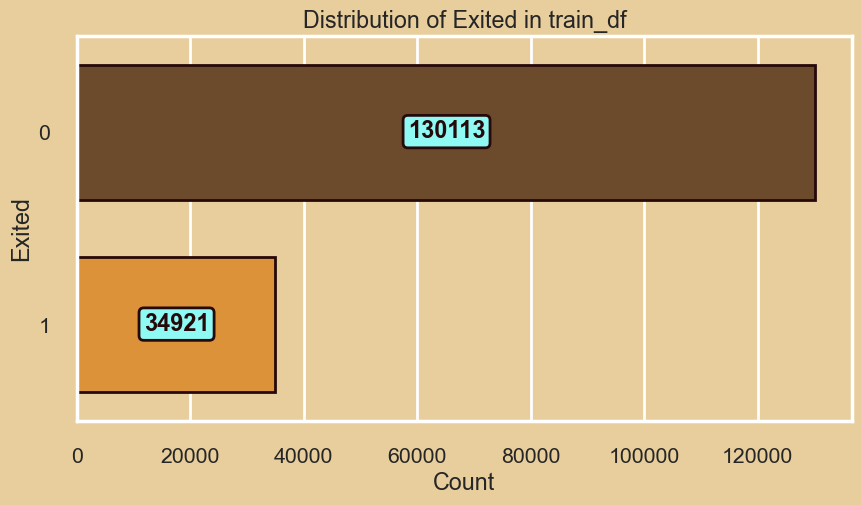

In [22]:
fig = plt.figure(figsize=(10, 5))


p = sns.countplot(y="Exited", data=train_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Exited in train_df")
plt.xlabel("Count")
plt.ylabel("Exited")

plt.show()


> ### ***Credit Score In The Dataset***

>> #### train_df

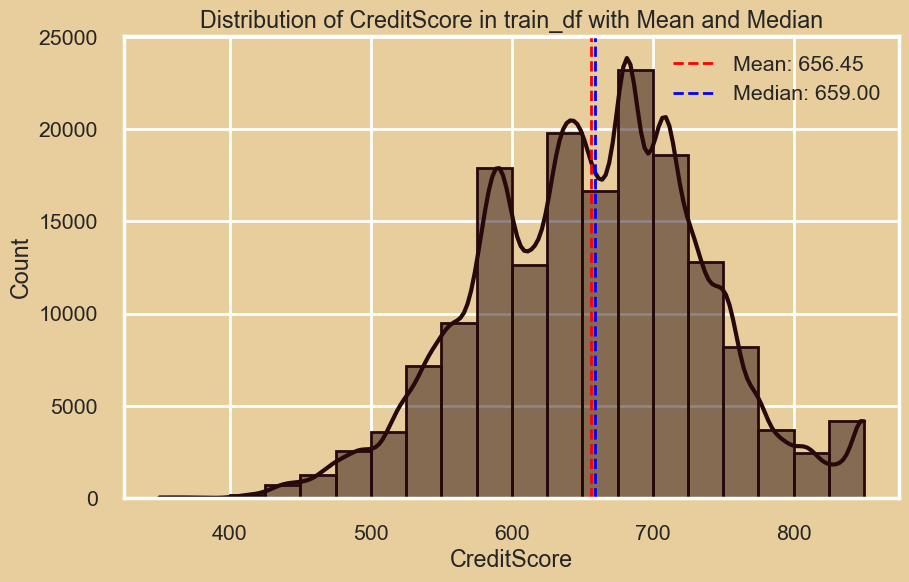

In [23]:
# Create a histogram for the "CreditScore" column with specified colors
fig = plt.figure(figsize=(10, 6))

histplot = sns.histplot(data=train_df, x="CreditScore", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = train_df["CreditScore"].mean()
median_value = train_df["CreditScore"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution of CreditScore in train_df with Mean and Median")
plt.xlabel("CreditScore")
plt.ylabel("Count")

# Show legend
plt.legend()

plt.show()


>> #### test_df

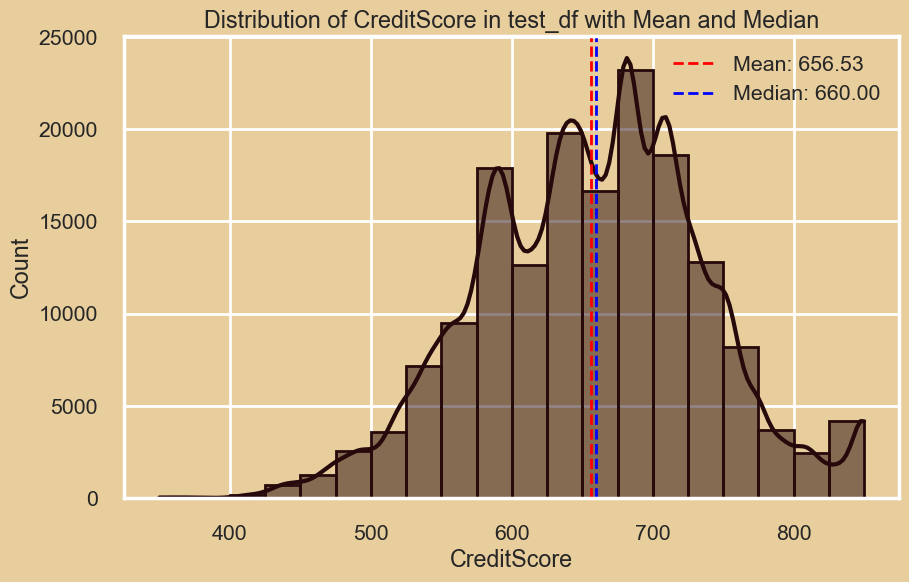

In [24]:
# Create a histogram for the "CreditScore" column with specified colors
fig = plt.figure(figsize=(10, 6))

histplot = sns.histplot(data=train_df, x="CreditScore", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = test_df["CreditScore"].mean()
median_value = test_df["CreditScore"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution of CreditScore in test_df with Mean and Median")
plt.xlabel("CreditScore")
plt.ylabel("Count")

# Show legend
plt.legend()

plt.show()


> ### ***Geography In The Dataset***

>> #### train_df

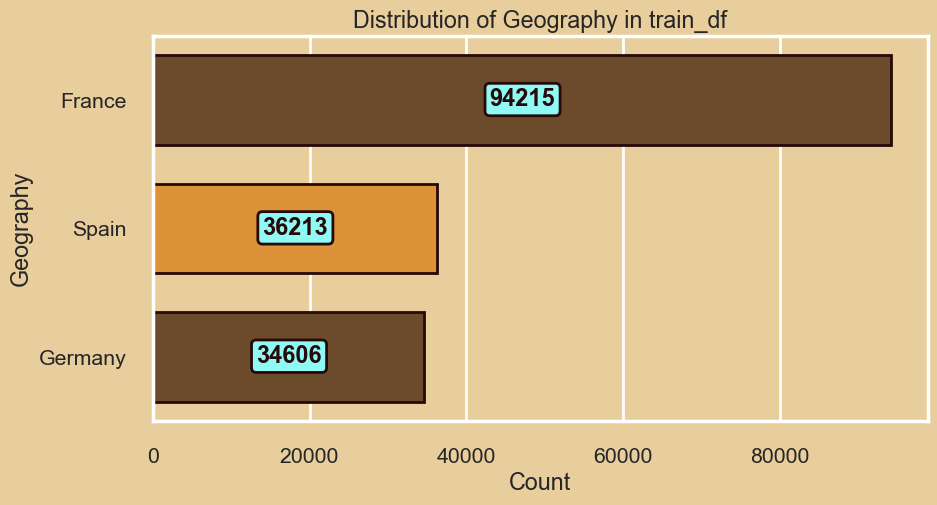

In [25]:
fig = plt.figure(figsize=(10, 5))


p = sns.countplot(y="Geography", data=train_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Geography in train_df")
plt.xlabel("Count")
plt.ylabel("Geography")

plt.show()


>> #### test_df

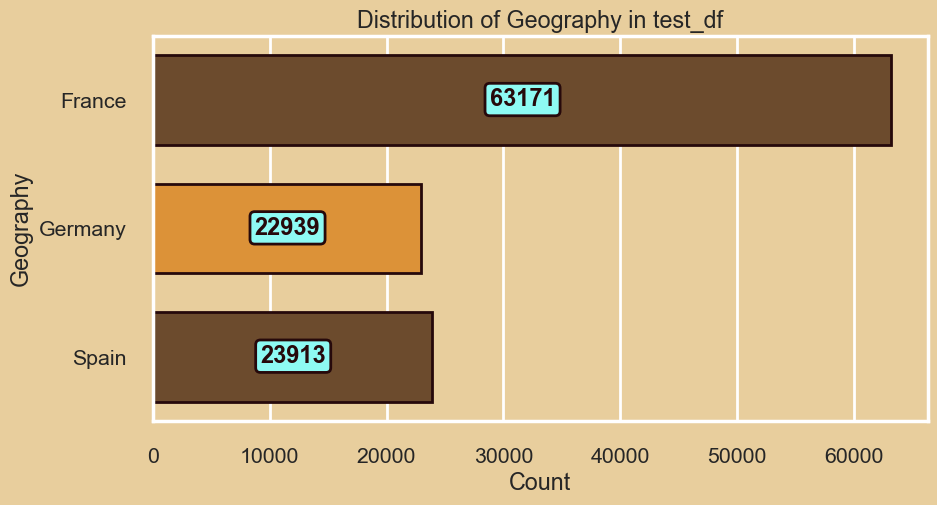

In [26]:
fig = plt.figure(figsize=(10, 5))


p = sns.countplot(y="Geography", data=test_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Geography in test_df")
plt.xlabel("Count")
plt.ylabel("Geography")

plt.show()


> ### ***Gender In The Dataset***

>> #### train_df

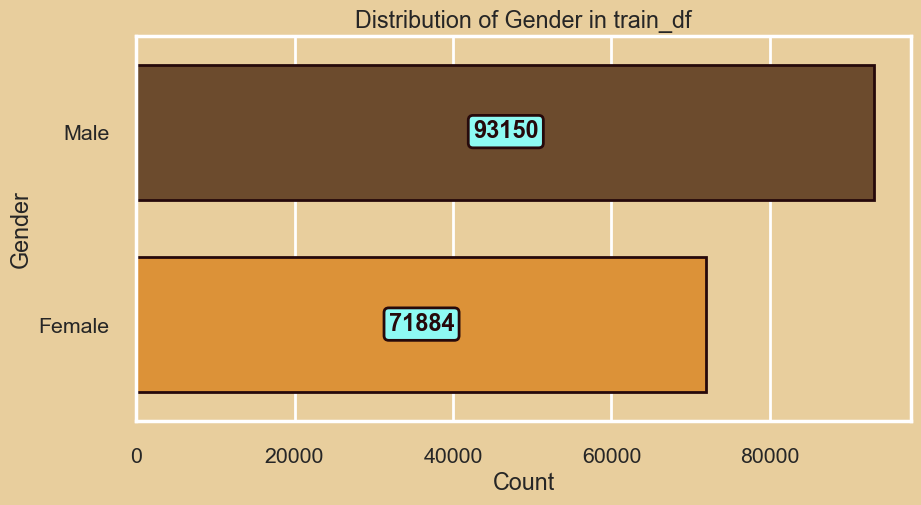

In [27]:

fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="Gender", data=train_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Gender in train_df")
plt.xlabel("Count")
plt.ylabel("Gender")

plt.show()


>> #### test_df

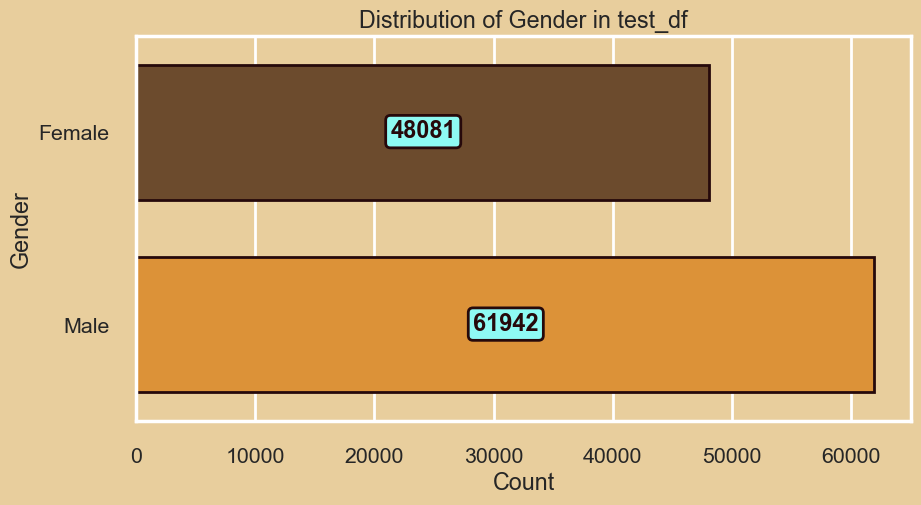

In [28]:

fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="Gender", data=test_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Gender in test_df")
plt.xlabel("Count")
plt.ylabel("Gender")

plt.show()

> ### ***Age In The Dataset***

>> #### train_df

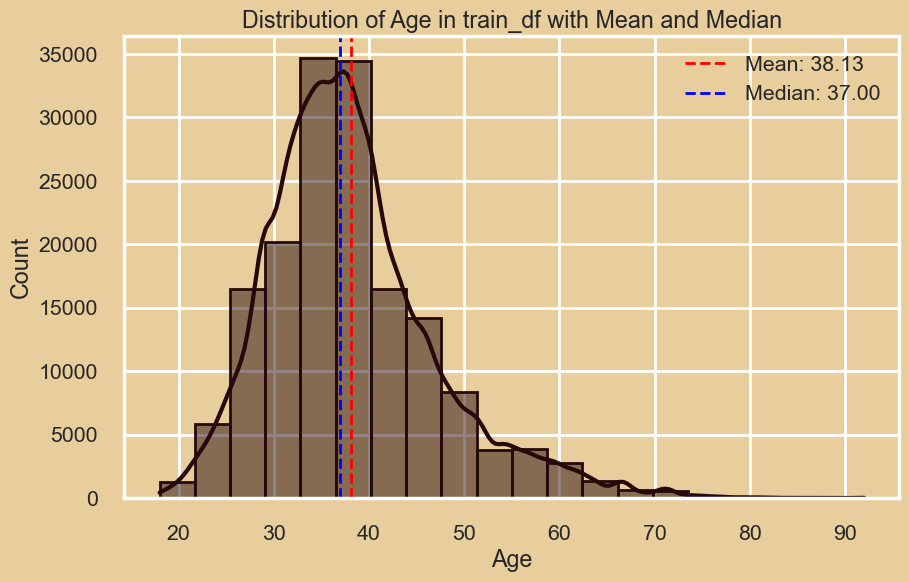

In [29]:
# Create a histogram for the "Age" column with specified colors
fig = plt.figure(figsize=(10, 6))

histplot = sns.histplot(data=train_df, x="Age", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = train_df["Age"].mean()
median_value = train_df["Age"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution of Age in train_df with Mean and Median")
plt.xlabel("Age")
plt.ylabel("Count")

# Show legend
plt.legend()

plt.show()


>> #### test_df

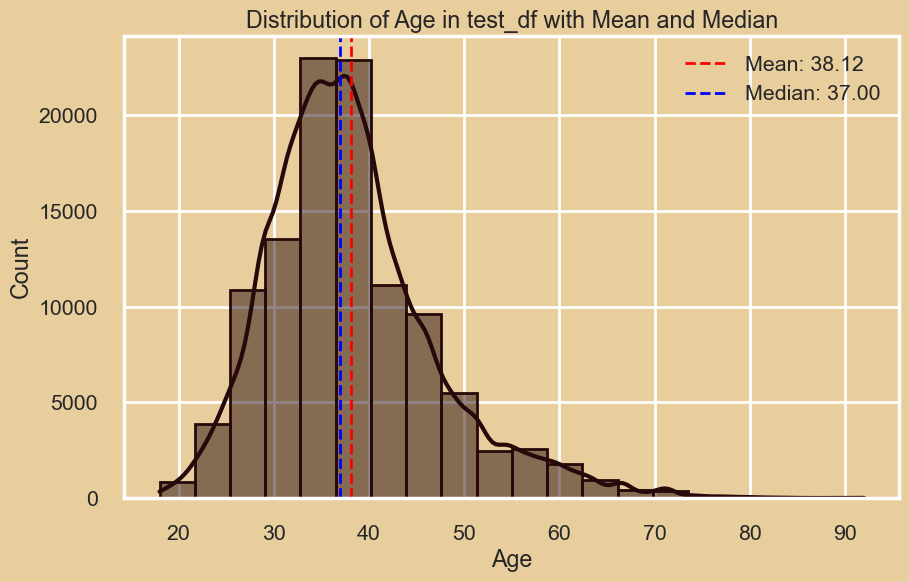

In [30]:
# Create a histogram for the "Age" column with specified colors
fig = plt.figure(figsize=(10, 6))

histplot = sns.histplot(data=test_df, x="Age", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = test_df["Age"].mean()
median_value = test_df["Age"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution of Age in test_df with Mean and Median")
plt.xlabel("Age")
plt.ylabel("Count")

# Show legend
plt.legend()

plt.show()


> ### ***Tenure In The Dataset***

>> #### train_df

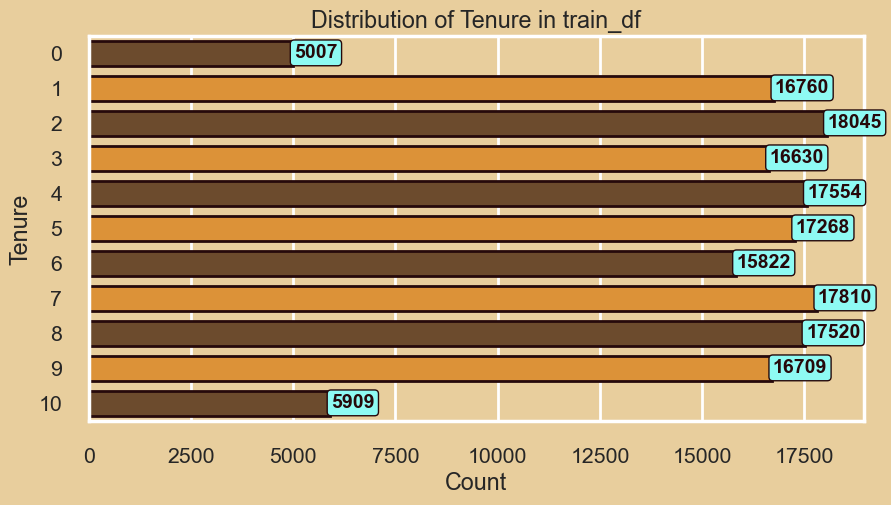

In [31]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="Tenure", data=train_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="edge", color='#26090b', fontsize=14, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 1, "alpha": 1})

plt.title("Distribution of Tenure in train_df")
plt.xlabel("Count")
plt.ylabel("Tenure")

plt.show()


>> #### test_df

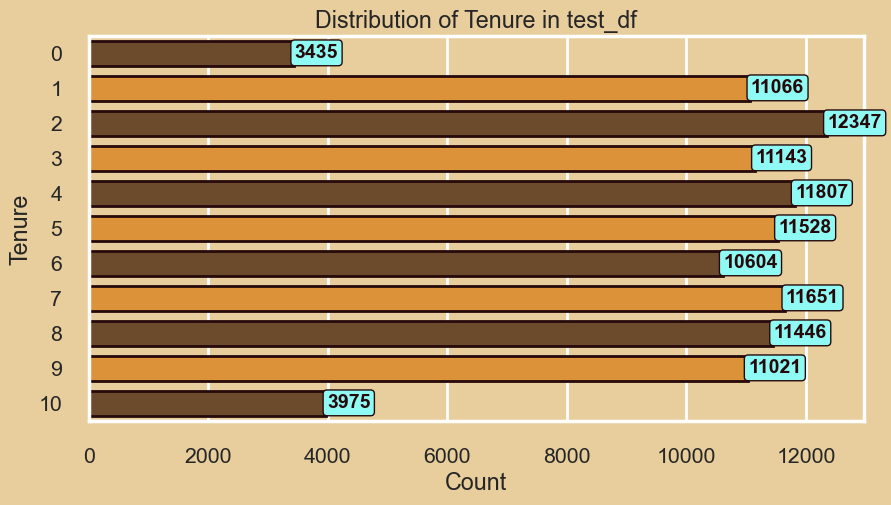

In [32]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="Tenure", data=test_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="edge", color='#26090b', fontsize=14, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 1, "alpha": 1})

plt.title("Distribution of Tenure in test_df")
plt.xlabel("Count")
plt.ylabel("Tenure")

plt.show()

> ### ***Balance In The Dataset***

>> #### train_df

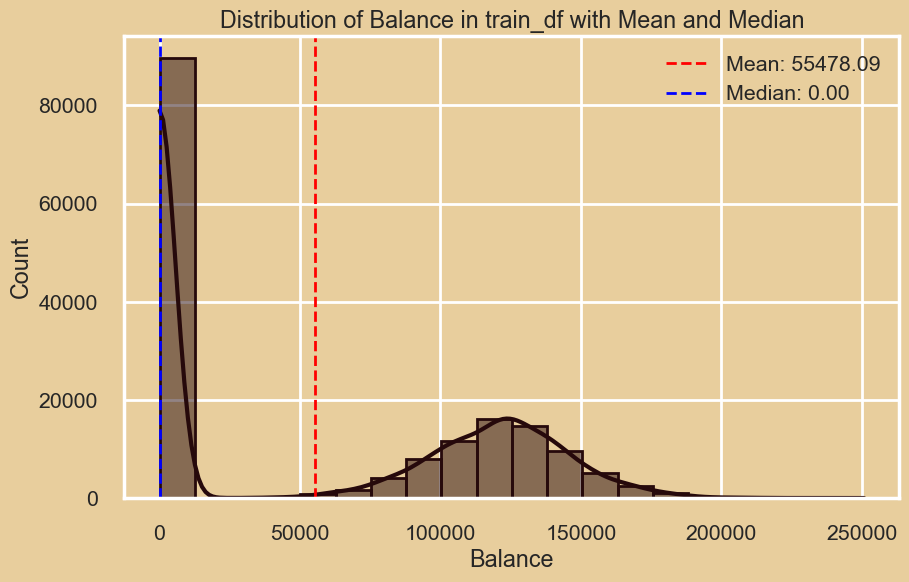

In [33]:
# Create a histogram for the "Balance" column with specified colors
fig= plt.figure(figsize=(10, 6))


histplot = sns.histplot(data=train_df, x="Balance", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = train_df["Balance"].mean()
median_value = train_df["Balance"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution of Balance in train_df with Mean and Median")
plt.xlabel("Balance")
plt.ylabel("Count")

# Show legend
plt.legend()

plt.show()

>> #### test_df

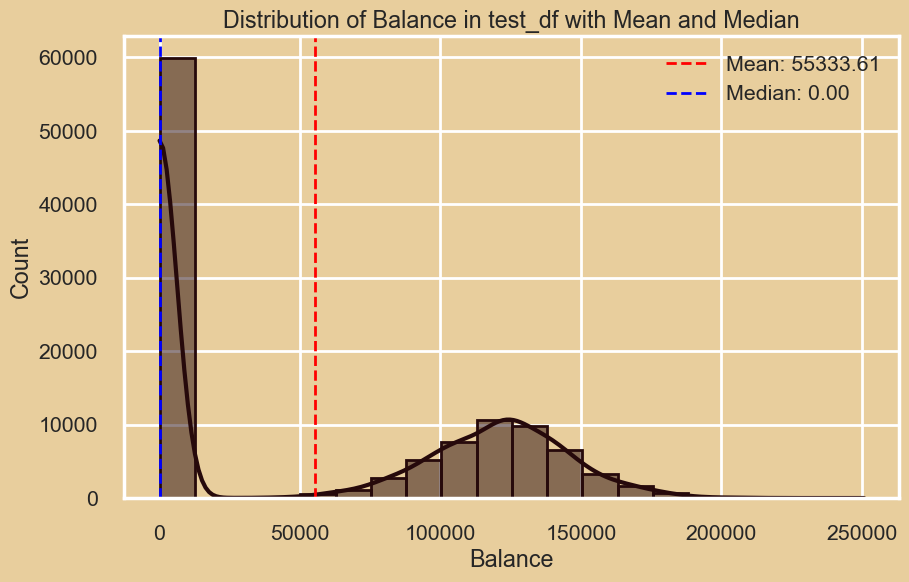

In [34]:
# Create a histogram for the "Balance" column with specified colors
fig= plt.figure(figsize=(10, 6))


histplot = sns.histplot(data=test_df, x="Balance", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = test_df["Balance"].mean()
median_value = test_df["Balance"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution of Balance in test_df with Mean and Median")
plt.xlabel("Balance")
plt.ylabel("Count")

# Show legend
plt.legend()

plt.show()

> ### ***Number Of Products In The Dataset***

>> #### train_df

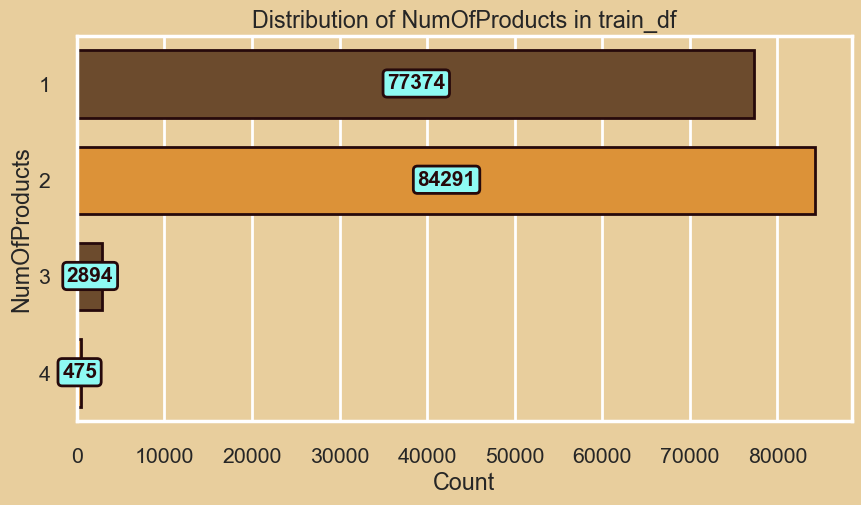

In [35]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="NumOfProducts", data=train_df, palette=palette[0:2]
                  , edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=15, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of NumOfProducts in train_df")
plt.xlabel("Count")
plt.ylabel("NumOfProducts")

plt.show()


>> #### test_df

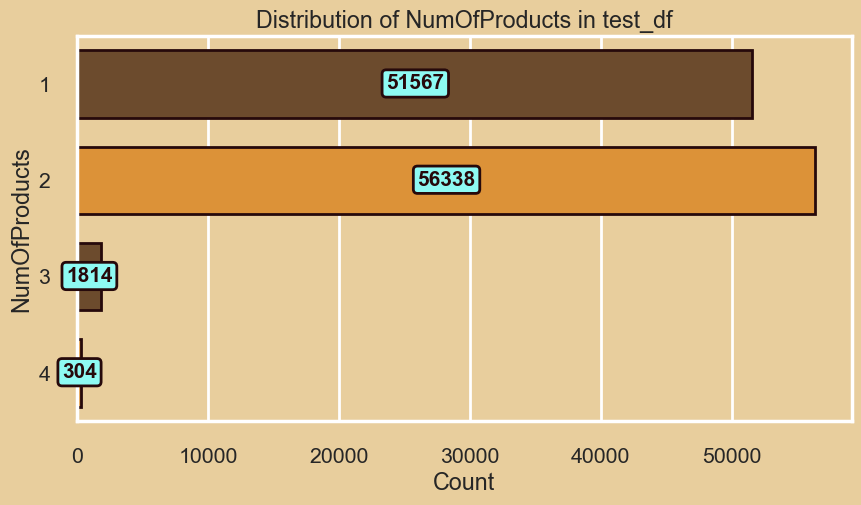

In [36]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="NumOfProducts", data=test_df, palette=palette[0:2]
                  , edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=15, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of NumOfProducts in test_df")
plt.xlabel("Count")
plt.ylabel("NumOfProducts")

plt.show()

> ### ***Customer Having Credit Card In The Dataset***

>> #### train_df

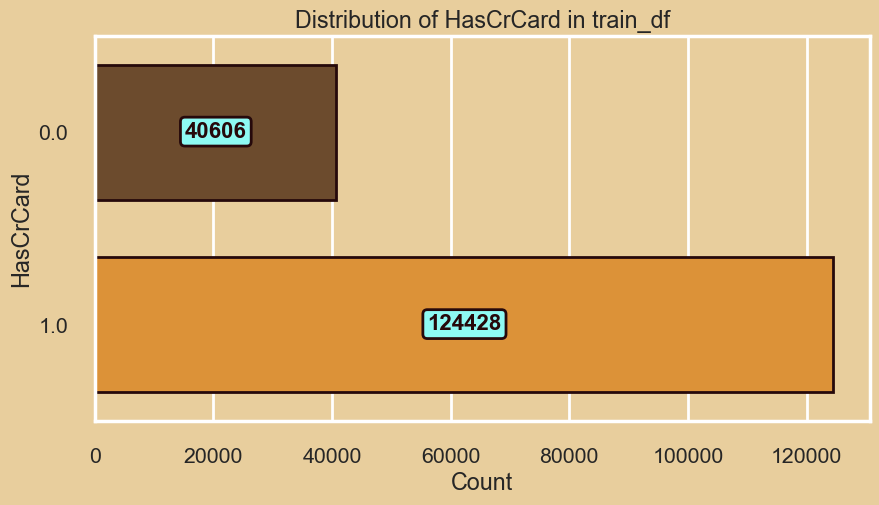

In [37]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="HasCrCard", data=train_df, palette=palette[0:2]
                  , edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=16, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of HasCrCard in train_df")
plt.xlabel("Count")
plt.ylabel("HasCrCard")

plt.show()


>> #### test_df

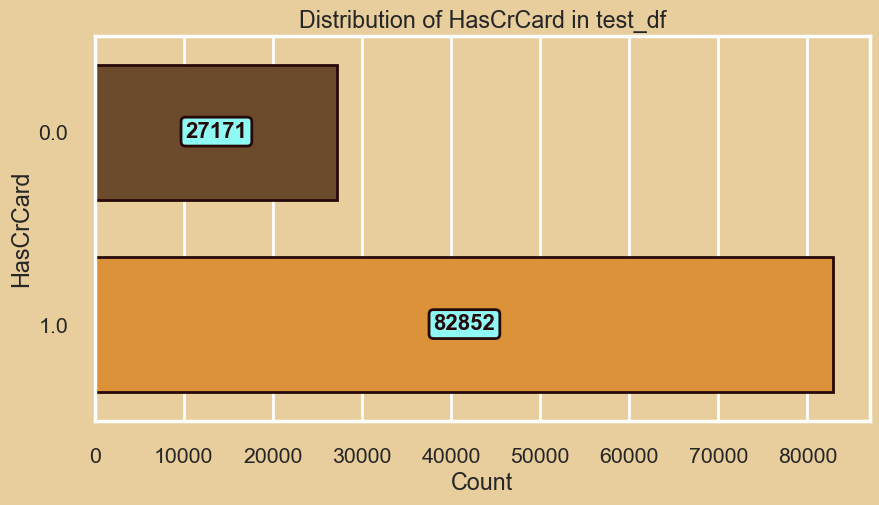

In [38]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="HasCrCard", data=test_df, palette=palette[0:2]
                  , edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=16, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of HasCrCard in test_df")
plt.xlabel("Count")
plt.ylabel("HasCrCard")

plt.show()


> ### ***Active Customers In The Dataset***

>> #### train_df

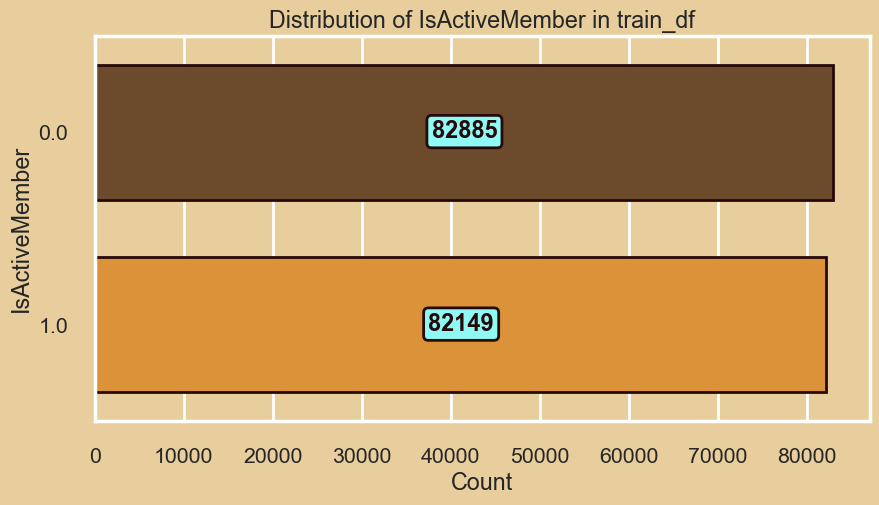

In [39]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="IsActiveMember", data=train_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of IsActiveMember in train_df")
plt.xlabel("Count")
plt.ylabel("IsActiveMember")

plt.show()


>> #### test_df

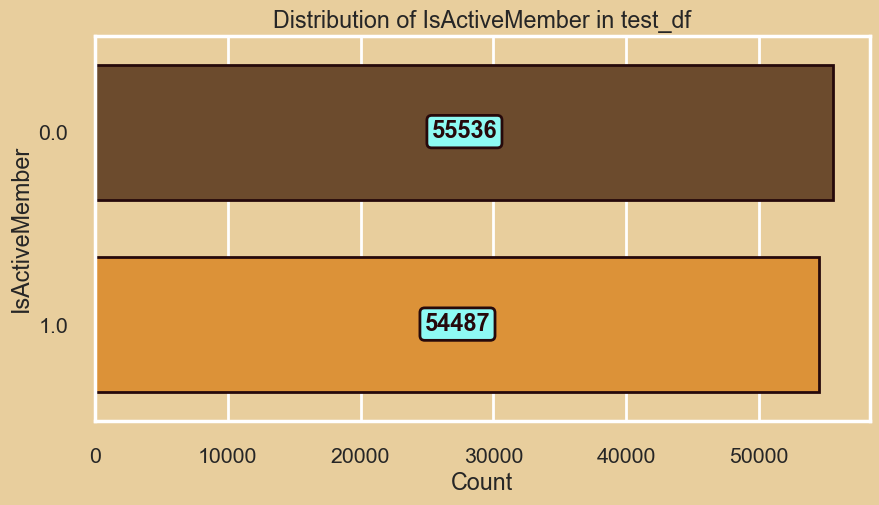

In [40]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="IsActiveMember", data=test_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of IsActiveMember in test_df")
plt.xlabel("Count")
plt.ylabel("IsActiveMember")

plt.show()


> ### ***Estimated Salary In The Dataset***

>> #### train_df

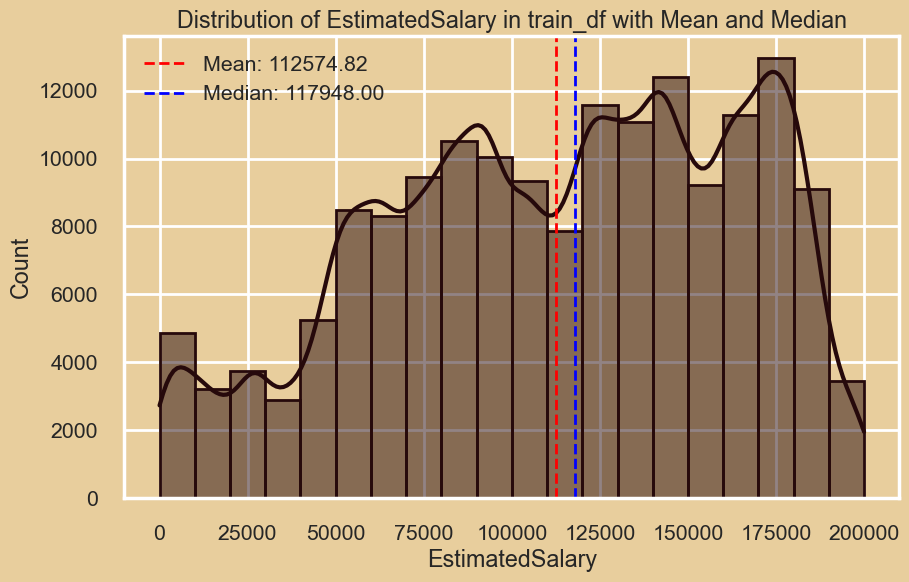

In [41]:
# Create a histogram for the "EstimatedSalary" column with specified colors
fig = plt.figure(figsize=(10, 6))


histplot = sns.histplot(data=train_df, x="EstimatedSalary", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = train_df["EstimatedSalary"].mean()
median_value = train_df["EstimatedSalary"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution of EstimatedSalary in train_df with Mean and Median")
plt.xlabel("EstimatedSalary")
plt.ylabel("Count")

# Show legend
plt.legend()

plt.show()

>> #### test_df

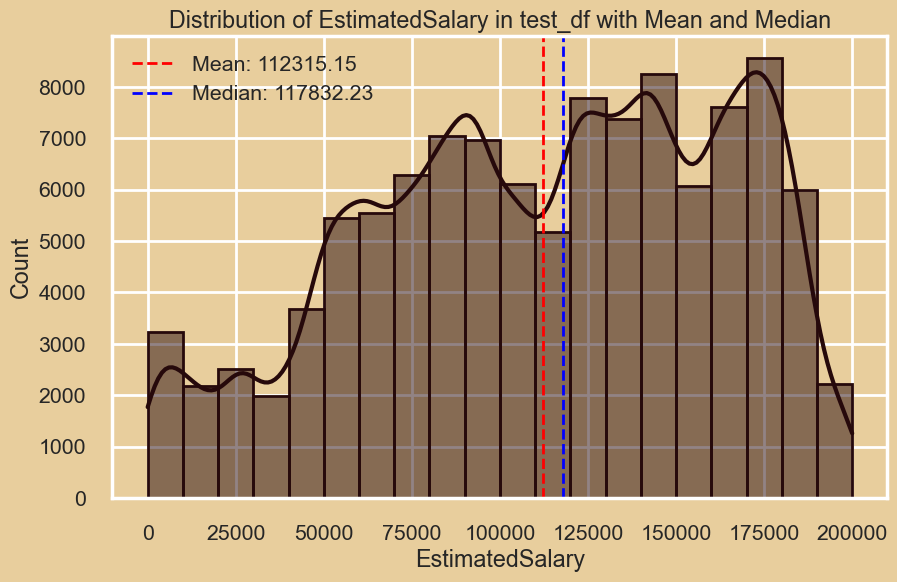

In [42]:
# Create a histogram for the "EstimatedSalary" column with specified colors
fig = plt.figure(figsize=(10, 6))


histplot = sns.histplot(data=test_df, x="EstimatedSalary", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = test_df["EstimatedSalary"].mean()
median_value = test_df["EstimatedSalary"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution of EstimatedSalary in test_df with Mean and Median")
plt.xlabel("EstimatedSalary")
plt.ylabel("Count")

# Show legend
plt.legend()

plt.show()

> ### ***Countplot by Target***

>> #### train_df

In [43]:
cat_cols = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember']

num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

target = 'Exited'

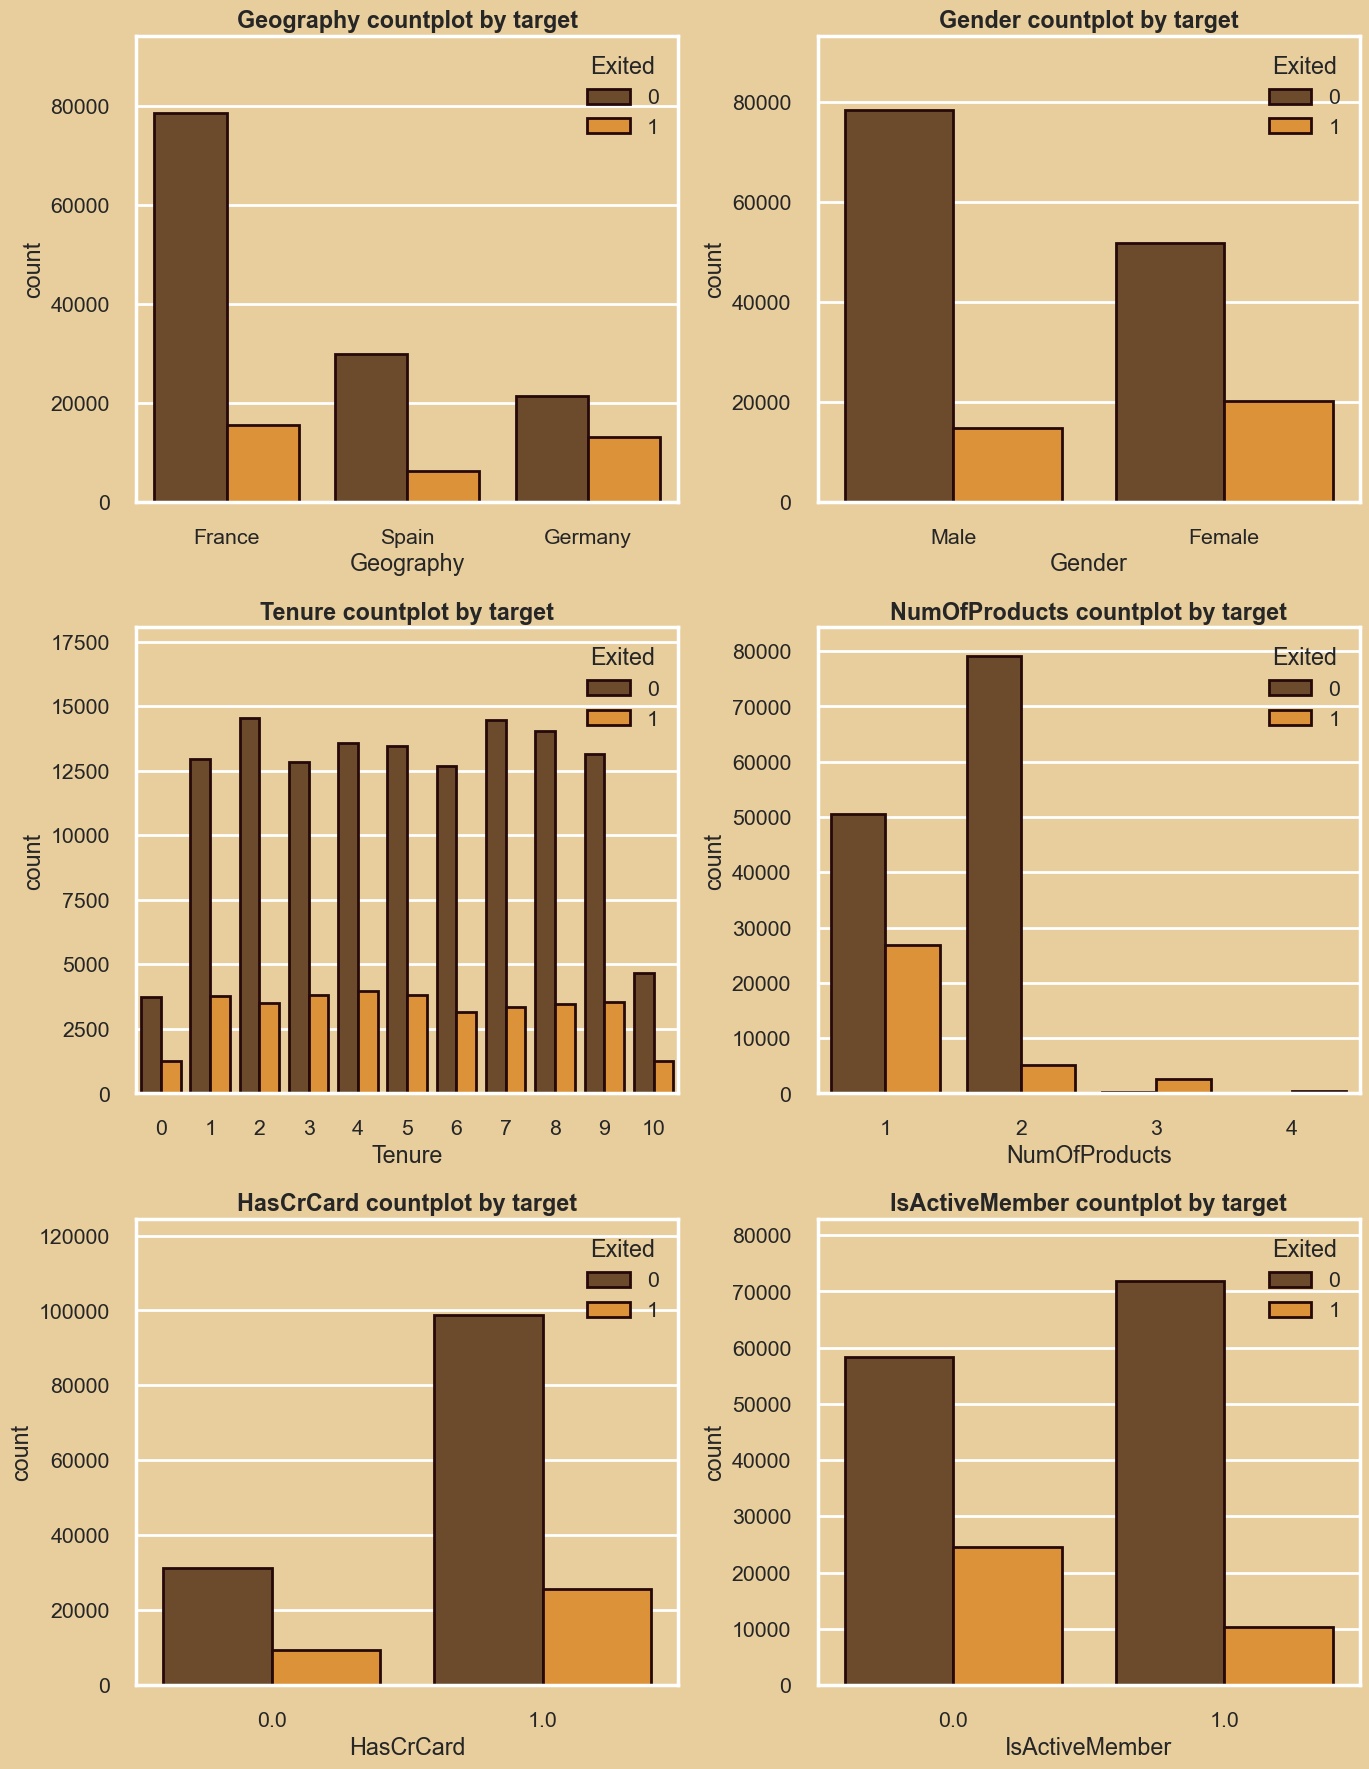

In [44]:
fig = plt.figure(figsize=(14, len(cat_cols)*3))

# background_color = 'grey'
for i, col in enumerate(cat_cols):
    
    plt.subplot(len(cat_cols)//2 + len(cat_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue=target, data=train_df, palette=palette[0:2], color='#26090b', edgecolor='#26090b')
    plt.title(f"{col} countplot by target", fontweight = 'bold')
    plt.ylim(0, train_df[col].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

<Axes: >

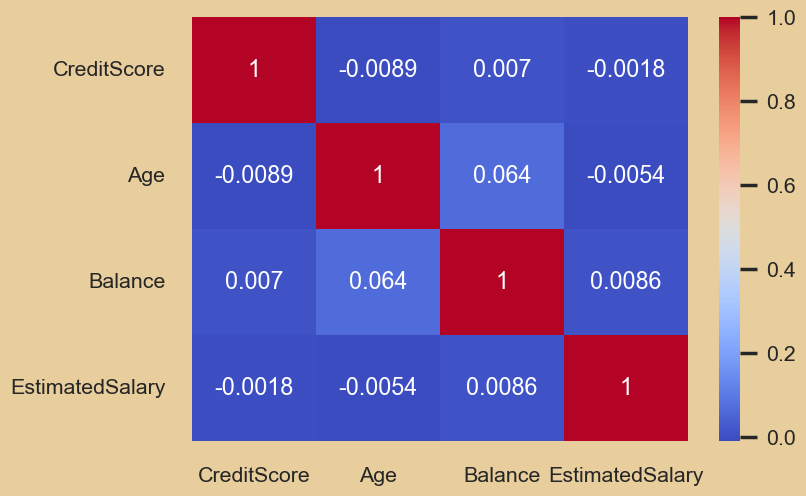

In [45]:
corr = train_df[num_cols].corr()
sns.heatmap(corr,cmap='coolwarm',annot=True)

>> #### test_df

<Axes: >

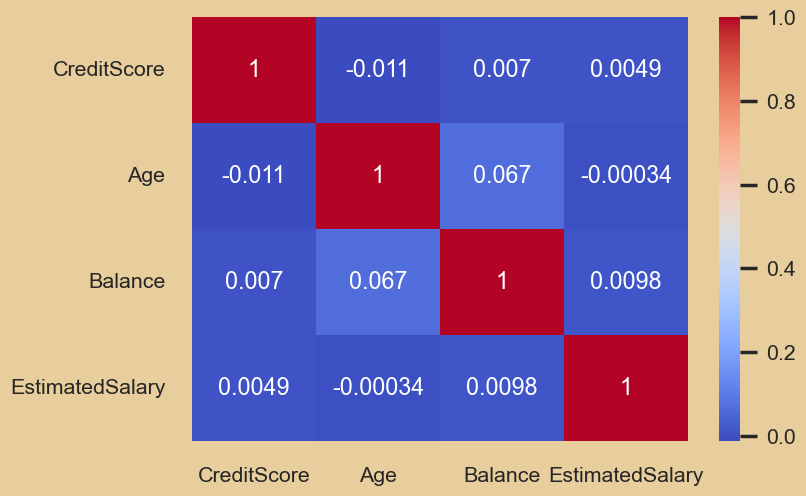

In [46]:
corr = test_df[num_cols].corr()
sns.heatmap(corr,cmap='coolwarm',annot=True)

In [ ]:
train_df.to_csv("../data/cleaned data/train_df.csv", index=False)